# **A Bayesian Network to model road accident in the metropolitan city of Bologna**.

by Ludovico Granata\
*Fundamentals of Artificial Intelligence and Knowledge Representation, module 3. Professor Paolo Torroni.*


---





Nowadays road accident are one of the leading cause of death, especially between young people. Each year, 1.35 million people are killed on roadways around the world [[1]](#first). It is estimated that fatal and nonfatal crash injuries will cost the world economy approximately $1.8 trillion dollars from 2015–2030[[2]](#second).\
Analyse how the circumnstances of the accident affects the type of the crash and the total casualties can help to build better safety measures.\
In this notebook I will do this analysis using Bayesian Networks with the aim of providing a model that can give probabilistic results given some input evidence.\
This project was inspired by a paper by Xin Zou and Wen Long Yue from the University of Australia [[3]](#third).



##The dataset
The data to compute the conditional probability table of the model are taken from ISTAT (Italian National Institute of Statistics) in the form of **microdata** that is data on the characteristics of units of a population, such as individuals collected by a census, survey, or experiment [[4]](#fourth).\
The data describes only accident that have caused some kind of injuries to people in the year 2019.
The dataset had a lot of attribute that will not be used (like genders, age, etc...), and some attributes needed to be cleaned. But the process of datacleaning was not the object of this course so will not be reported it in this notebook.


In [1]:
import pandas as pd
import numpy as np

In [2]:
# Mounting my Google Drive and set the cd on the path /content/drive/My Drive/SMM_labs 
# the directory I want to work in is SMM_labs.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/FAKR3

Mounted at /content/drive/
/content/drive/My Drive/FAKR3


In [4]:
df = pd.read_csv("data_cleaned.csv")
df_bologna = df[df["provincia"]==37]
df_bologna = df_bologna.drop(["Unnamed: 0", "provincia"], 1)
print ("The dataset have {0} entries and {1} attributes".format(df_bologna.shape[0], df_bologna.shape[1]))
df_bologna.head()

The dataset have 3805 entries and 10 attributes


,Road_geometry,Road_moisture_condition,Traffic_control,Weather_condition,Crash_type,Total_serious_injuries,Time_of_the_day,Total_casualties,Total_units_involved,Driver_apparent_error
744,Rettilineo,Bagnato,Verticale e orizzontale,Sereno,"Fuoriuscita, sbandamento",4,mattina,0,1,NaN
745,Rettilineo,Asciutto,Verticale e orizzontale,Sereno,Tamponamento,1,sera,0,2,Procedeva con guida distratta o andamento inde...
746,Rettilineo,Bagnato,Verticale e orizzontale,Neve,"Fuoriuscita, sbandamento",1,sera,0,1,NaN
747,Rettilineo,Asciutto,Verticale e orizzontale,Sereno,Tamponamento,2,mattina,0,6,Procedeva senza mantenere la distanza di sicur...
748,Curva,Asciutto,Verticale e orizzontale,Sereno,Scontro laterale,3,mattina,0,2,NaN


## Bayesian Network model
The structure of the model was inspired from a paper by Xin Zou and Wen Long Yue from the University of Australia where they build the Bayesian Network with the help of a expert of the field[[3]](#third).

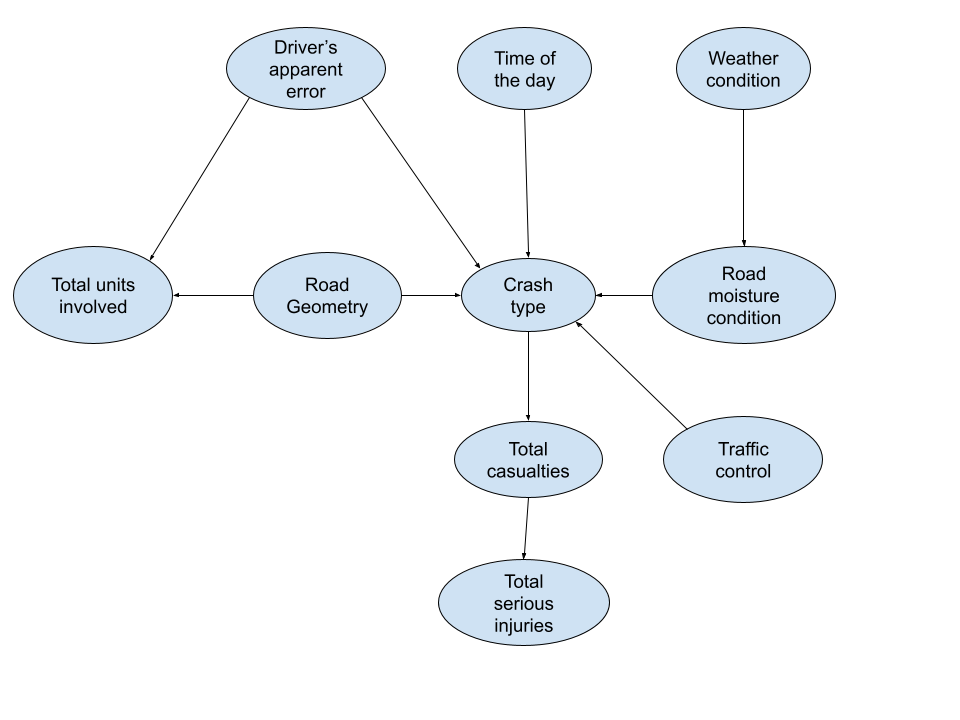

So in the following we create the Bayesian network using the pgmpy library.

In [6]:
ok = !pip install pgmpy

In [7]:
from pgmpy.models import BayesianModel

In [8]:
model = BayesianModel([('Weather_condition', 'Road_moisture_condition'),   ('Road_moisture_condition', 'Crash_type'),   ('Time_of_the_day', 'Crash_type'),
                       ('Driver_apparent_error', 'Crash_type'),  ('Road_geometry', 'Crash_type'),   ('Traffic_control', 'Crash_type'),
                       ('Crash_type', 'Total_casualties'),  ('Total_casualties','Total_serious_injuries'),
                       ('Driver_apparent_error', 'Total_units_involved'), ('Road_geometry', 'Total_units_involved')])

## Learning the CPT tables


In [9]:
from pgmpy.estimators import MaximumLikelihoodEstimator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
model.cpds = []
model.fit(data=df_bologna, 
          estimator=MaximumLikelihoodEstimator,
          complete_samples_only=False)

In [11]:
print('Check model: {0}\n'.format(model.check_model()))

Check model: True



# Analysis of the Bayesian network
Now we will investigate some properties of the  bayesian network:


*   Conditional indipendencies and Active trails
*   Markov blanket




In [12]:
#Total number of conditional indipendence assertion
print ("We can make a total of {0} different indipendence assertion".format(len(model.get_independencies().get_assertions())))
print ("="*40)

#Local Independencies: Any variable in the network is independent of its non-descendents given its parents.
print ("Local Independencies: Any variable in the network is independent of its non-descendents given its parents/n")
print (model.local_independencies(list(df_bologna.columns)))

#Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#that there is an active trail between A and B.
def active_trail (model, start_cond_variable, evidence):
  active_trails = model.active_trail_nodes(start_cond_variable, evidence).get(start_cond_variable)
  active_trails.remove(start_cond_variable)
  if active_trails :
    if evidence :
      print ("There is an active trail between {0} and {1} given the evidence{2}".format(start_cond_variable, active_trails, evidence))
    else:
      print ("There is an active trail between {0} and {1} given no evidence".format(start_cond_variable, active_trails))
  else:
    if evidence :
      print ("There is NO active trail starting from {0} given the evidence{2}".format(start_cond_variable, evidence))
    else:
      print ("There is NO active trail starting from {0} given no evidence".format(start_cond_variable))

#some example on the active trails:
print ("="*40)
active_trail (model, start_cond_variable="Crash_type", evidence=[])
active_trail (model, start_cond_variable="Total_casualties", evidence=[])
active_trail (model, start_cond_variable="Total_casualties", evidence=["Crash_type"])
#example for common effect active trail
active_trail (model, start_cond_variable="Time_of_the_day", evidence=[])
active_trail (model, start_cond_variable="Time_of_the_day", evidence=["Crash_type"])

#Markov blanket: each node is conditionally independent of all others
#given its Markov blanket (parents+children+ children's parents)--> very usefull if 
#we have very big network (not our case)
def markov_blanket(node):
    print("the Markov blanket of the node {0} is {1}".format(node, set(model.get_markov_blanket(node))))


print ("="*40)
markov_blanket ("Crash_type")
markov_blanket ("Total_casualties")
  


We can make a total of 3696 different indipendence assertion
Local Independencies: Any variable in the network is independent of its non-descendents given its parents/n
(Road_geometry ⟂ Driver_apparent_error, Weather_condition, Road_moisture_condition, Traffic_control, Time_of_the_day)
(Road_moisture_condition ⟂ Road_geometry, Driver_apparent_error, Total_units_involved, Traffic_control, Time_of_the_day | Weather_condition)
(Traffic_control ⟂ Total_units_involved, Road_geometry, Driver_apparent_error, Weather_condition, Road_moisture_condition, Time_of_the_day)
(Weather_condition ⟂ Total_units_involved, Road_geometry, Driver_apparent_error, Traffic_control, Time_of_the_day)
(Crash_type ⟂ Total_units_involved, Weather_condition | Road_geometry, Driver_apparent_error, Road_moisture_condition, Traffic_control, Time_of_the_day)
(Total_serious_injuries ⟂ Crash_type, Road_geometry, Road_moisture_condition, Time_of_the_day, Total_units_involved, Driver_apparent_error, Weather_condition, Traff

### Check assertion

In [13]:
from pgmpy.independencies.Independencies import IndependenceAssertion

def check_assertion (ind_var, variables, evidence):
    assertion = IndependenceAssertion(ind_var, variables, evidence)
    result = False
    for a in model.get_independencies().get_assertions():
        if assertion.event1 == a.event1 and assertion.event2 <= a.event2 and assertion.event3 == a.event3:
            result = True
            break
    return result

print (check_assertion ("Total_casualties",["Time_of_the_day"],["Crash_type"])) #true
print (check_assertion ("Total_casualties",["Time_of_the_day"], [])) #false
print (check_assertion ("Weather_condition",["Total_units_involved", "Road_geometry", "Driver_apparent_error", "Traffic_control", "Time_of_the_day"], [])) #true
print (check_assertion ("Weather_condition",["Total_units_involved", "Driver_apparent_error", "Time_of_the_day", "Traffic_control"], ["Road_geometry"])) #true




True
False
True
True


# Inference

In [14]:
from pgmpy.inference import VariableElimination
import time

Now we will permorm inference on our Bayesian network with the Variable Elimination method. The elimination order of the hidden variable is evaluated with heuristics functions. The heuristic function are the following:\


*   MinFill: The cost of a eliminating a node is the number of edges that need to be added (fill in edges) to the graph due to its elimination
*   MinNeighbors: The cost of a eliminating a node is the number of neighbors it has in the current graph.
* MinWeight: The cost of a eliminating a node is the product of weights, domain cardinality, of its neighbors.
*WeightedMinFill: The cost of eliminating a node is the sum of weights of the edges that need to be added to the graph due to its elimination, where a weight of an edge is the product of the weights, domain cardinality, of its constituent vertices.






In [44]:
from pgmpy.inference.EliminationOrder import WeightedMinFill
from pgmpy.inference.EliminationOrder import MinFill
from pgmpy.inference.EliminationOrder import MinNeighbors
from pgmpy.inference.EliminationOrder import MinWeight

def compare_heuristic_time(model, variables, evidence, hidden_variables):
  model_infer = VariableElimination(model)
  elimination_order_list = [MinFill, MinNeighbors, MinWeight, WeightedMinFill]  
  for elimination_order in elimination_order_list:
     ordering = elimination_order(model).get_elimination_order(hidden_variables, show_progress=False)
     start_time = time.time()
     model_infer.query(variables = variables,evidence=evidence,elimination_order=ordering, show_progress=False)
     print ("Inference with {0} heuristic computed in {1} and ordering {2}\n".format(elimination_order ,time.time() - start_time, ordering))

In [45]:
compare_heuristic_time (model, ["Crash_type"], {"Time_of_the_day":"mattina"}, ["Road_geometry", "Road_moisture_condition","Traffic_control", "Weather_condition",	"Total_serious_injuries",	"Total_casualties",	"Total_units_involved",	"Driver_apparent_error"] )

Inference with <class 'pgmpy.inference.EliminationOrder.MinFill'> heuristic computed in 3.407071590423584 and ordering ['Total_casualties', 'Total_serious_injuries', 'Road_moisture_condition', 'Total_units_involved', 'Road_geometry', 'Driver_apparent_error', 'Weather_condition', 'Traffic_control']

Inference with <class 'pgmpy.inference.EliminationOrder.MinNeighbors'> heuristic computed in 2.908363103866577 and ordering ['Total_serious_injuries', 'Total_casualties', 'Weather_condition', 'Total_units_involved', 'Road_geometry', 'Driver_apparent_error', 'Road_moisture_condition', 'Traffic_control']

Inference with <class 'pgmpy.inference.EliminationOrder.MinWeight'> heuristic computed in 2.964388847351074 and ordering ['Total_serious_injuries', 'Weather_condition', 'Total_casualties', 'Total_units_involved', 'Driver_apparent_error', 'Road_geometry', 'Road_moisture_condition', 'Traffic_control']

Inference with <class 'pgmpy.inference.EliminationOrder.WeightedMinFill'> heuristic computed 

Probability of Crash_type with [{'Time_of_the_day': 'mattina'}, {'Time_of_the_day': 'pomeriggio'}, {'Time_of_the_day': 'sera'}, {'Time_of_the_day': 'notte'}]


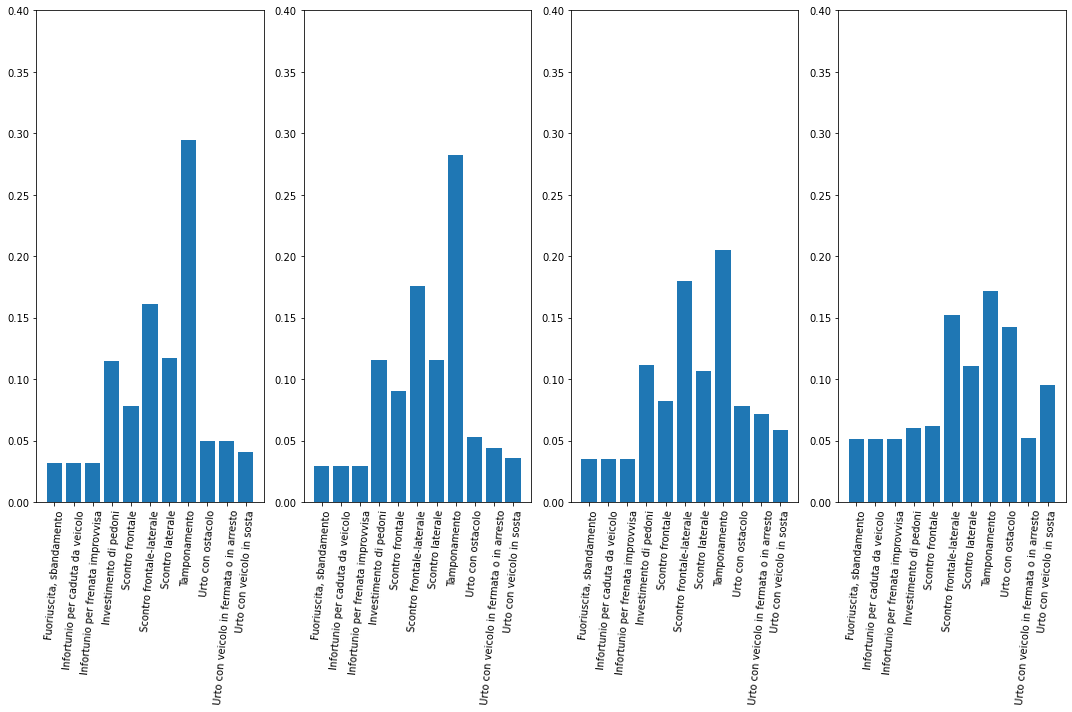

Probability of Crash_type with [{'Weather_condition': 'Sereno'}, {'Weather_condition': 'Neve'}, {'Weather_condition': 'Pioggia'}, {'Weather_condition': 'Nebbia'}]


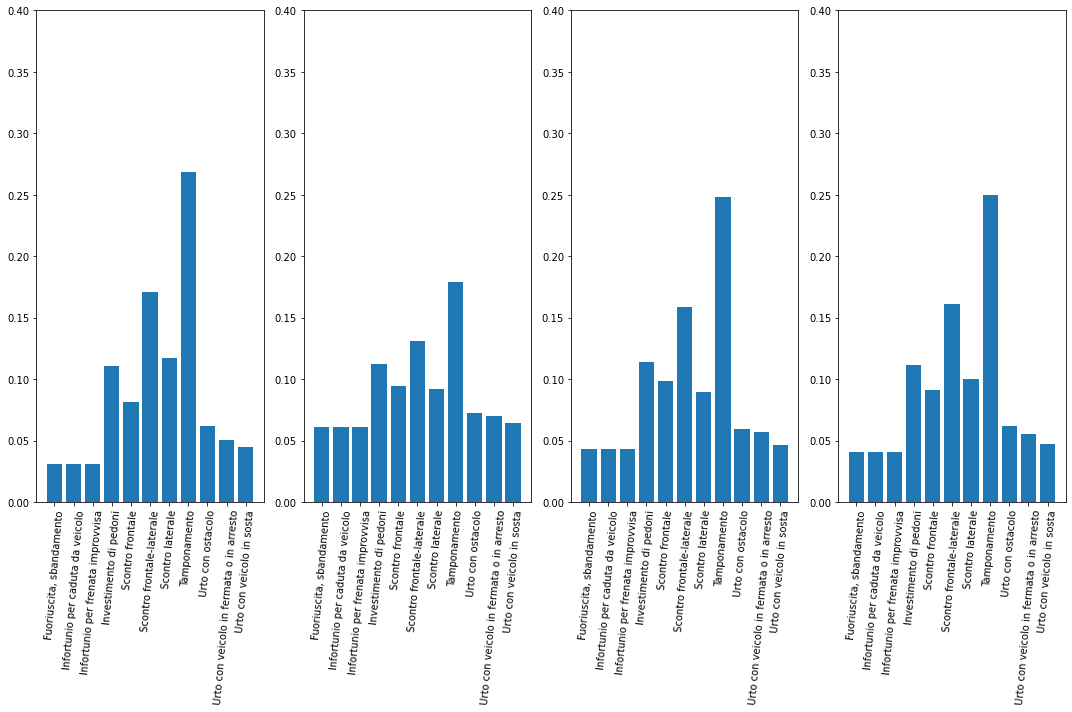

In [43]:
import matplotlib.pyplot as plt

def graphical_compare (model, query_var, evidence):
  if len(evidence)>1 :
    fig, axes = plt.subplots(nrows=(len(evidence)%4 +1), ncols=4, figsize=(15, 10))
    axes = axes.flatten()
    print ("Probability of {0} with {1}".format(query_var,evidence))
    for i in range(len(evidence)) :
      model_infer = VariableElimination(model)
      results = model_infer.query([query_var], evidence=evidence[i], show_progress=False)
      axes[i].bar(results.state_names[query_var], results.values)
      axes[i].set_xticklabels (results.state_names[query_var], rotation=85)
      axes[i].set_ylim(0,0.4)
    
    fig.tight_layout()
    plt.show()

  else : 
    model_infer = VariableElimination(model)
    results = model_infer.query([query_var], evidence=evidence, show_progress=False)
    fig = plt.figure()
    ax= fig.add_axes([0,0,1,1])
    ax.bar(results.state_names[query_var],results.values)
    ax.set_xticklabels (results.state_names[query_var], rotation=85)
    plt.show()

graphical_compare (model, "Crash_type",[ {"Time_of_the_day":"mattina"}, {"Time_of_the_day":"pomeriggio"}, {"Time_of_the_day":"sera"}, {"Time_of_the_day":"notte"}])
graphical_compare (model, "Crash_type",[{"Weather_condition": "Sereno"}, {"Weather_condition": "Neve"}, {"Weather_condition": "Pioggia"}, {"Weather_condition": "Nebbia"}, ]) 

# References

<a name="first">[1]</a> [*World Health Organization (WHO). Global Status Report on Road Safety 2018. December 2018.*](https://www.who.int/violence_injury_prevention/road_safety_status/2018/en/external)

<a name="second">[2]</a> [*Chen S, Kuhn M, Prettner K, Bloom DE. The global macroeconomic burden of road injuries: estimates and projections for 166 countries*](https://www.sciencedirect.com/science/article/pii/S2542519619301706)

<a name="third">[3]</a> [*Xin Zou, Wen Long Yue, "A Bayesian Network Approach to Causation Analysis of Road Accidents Using Netica", Journal of Advanced Transportation, vol. 2017, Article ID 2525481, 18 pages, 2017.*](https://doi.org/10.1155/2017/2525481)

<a name="fourth">[4]</a> [*RILEVAZIONE DEGLI INCIDENTI STRADALI CON LESIONI A PERSONE: MICRODATI AD USO PUBBLICO*](https://www.istat.it/it/archivio/87539)
